In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import tfs

from config import BEAM
from rdt_constants import FREQ_OUT_DIR
from rdt_functions import (
    get_rdts_from_optics_analysis,
    run_harpy
)
from tbt_denoiser import denoise_tbt
from analysis import process_tbt_data, format_noise
from visualisation import plot_denoised_data_from_files
plt.rcParams.update({"font.size": 16})
COLOURS = [
    "#0072B2",  # Blue
    "#D55E00",  # Red
    "#009E73",  # Green
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#F0E442",  # Yellow
    "#CC79A7",  # Pink
    "#000000",  # Black
]
NOISE = 1e-4

ln: failed to create symbolic link '/home/jovyan/autocleaner/acc-models-lhc': File exists


In [2]:
tbt_file_noisy, tbt_file_clean = process_tbt_data(NOISE)
tbt_file_zero = process_tbt_data(0.0)
# Example usage (update the paths as needed):
autoencoder_path = "conv_autoencoder.pth"  # path to your saved model
tbt_file_auto = denoise_tbt(autoencoder_path, tbt_file_noisy)
print("Cleaned file written to:", tbt_file_auto)

Writing datashape with: (2, 563, 1000)
Cleaned file written to: /home/jovyan/autocleaner/data/tbt_b1_1000t_denoised.sdds


torch.Size([2, 563, 1000])
torch.Size([2, 563, 1000])
torch.Size([2, 563, 1000])
Denoised spectrum plot saved as denoised_spectrum_xy_from_tbt.png.
TBT data plot saved as tbt_data_from_tbt.png.
TBT difference plot saved as tbt_diff_from_tbt.png.


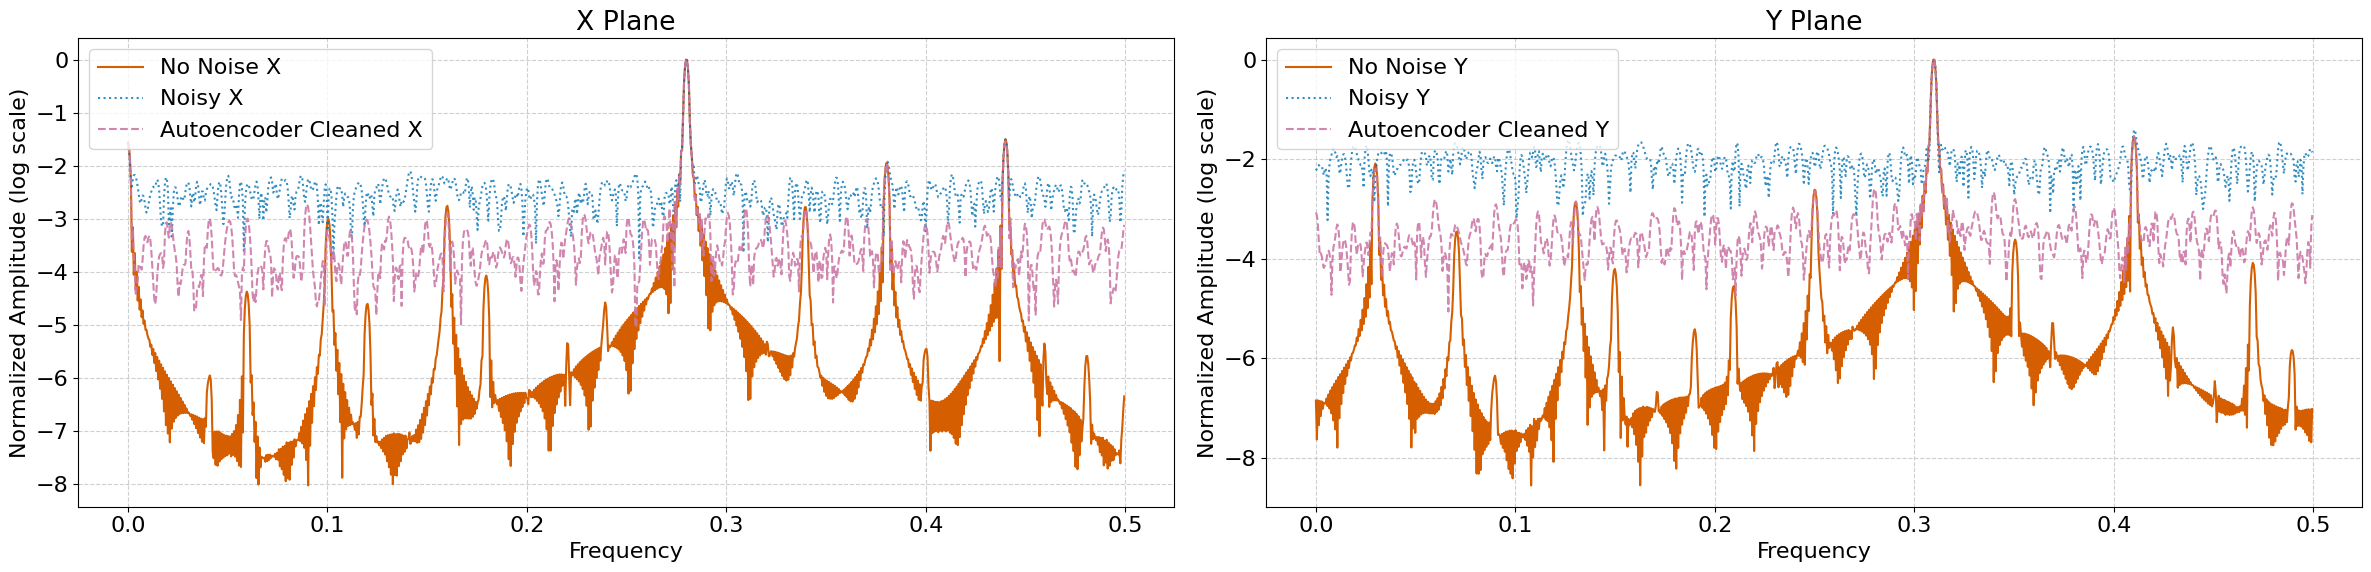

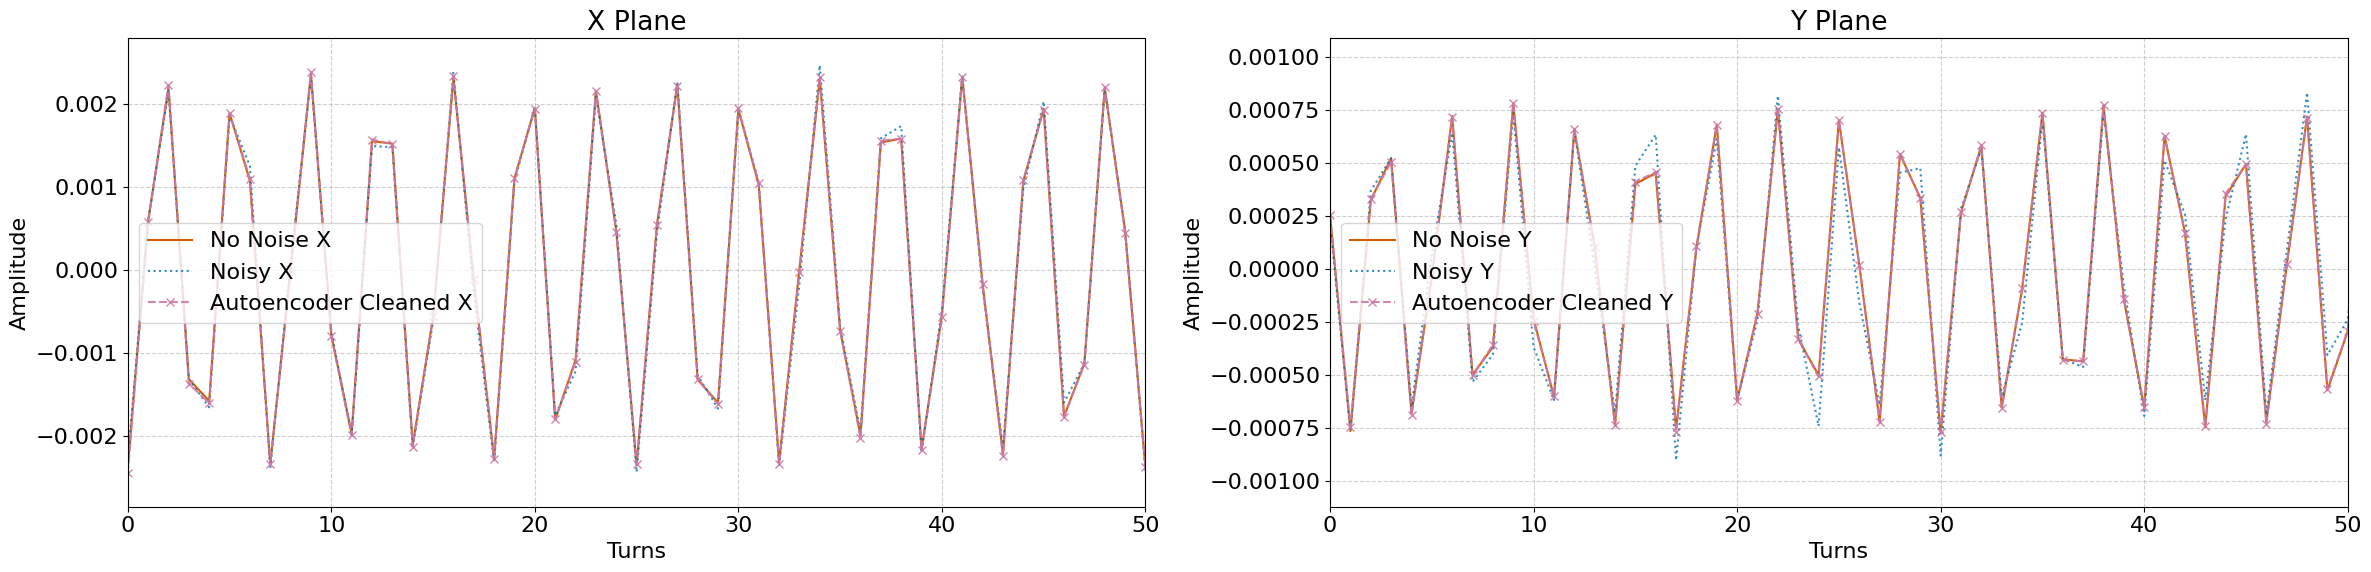

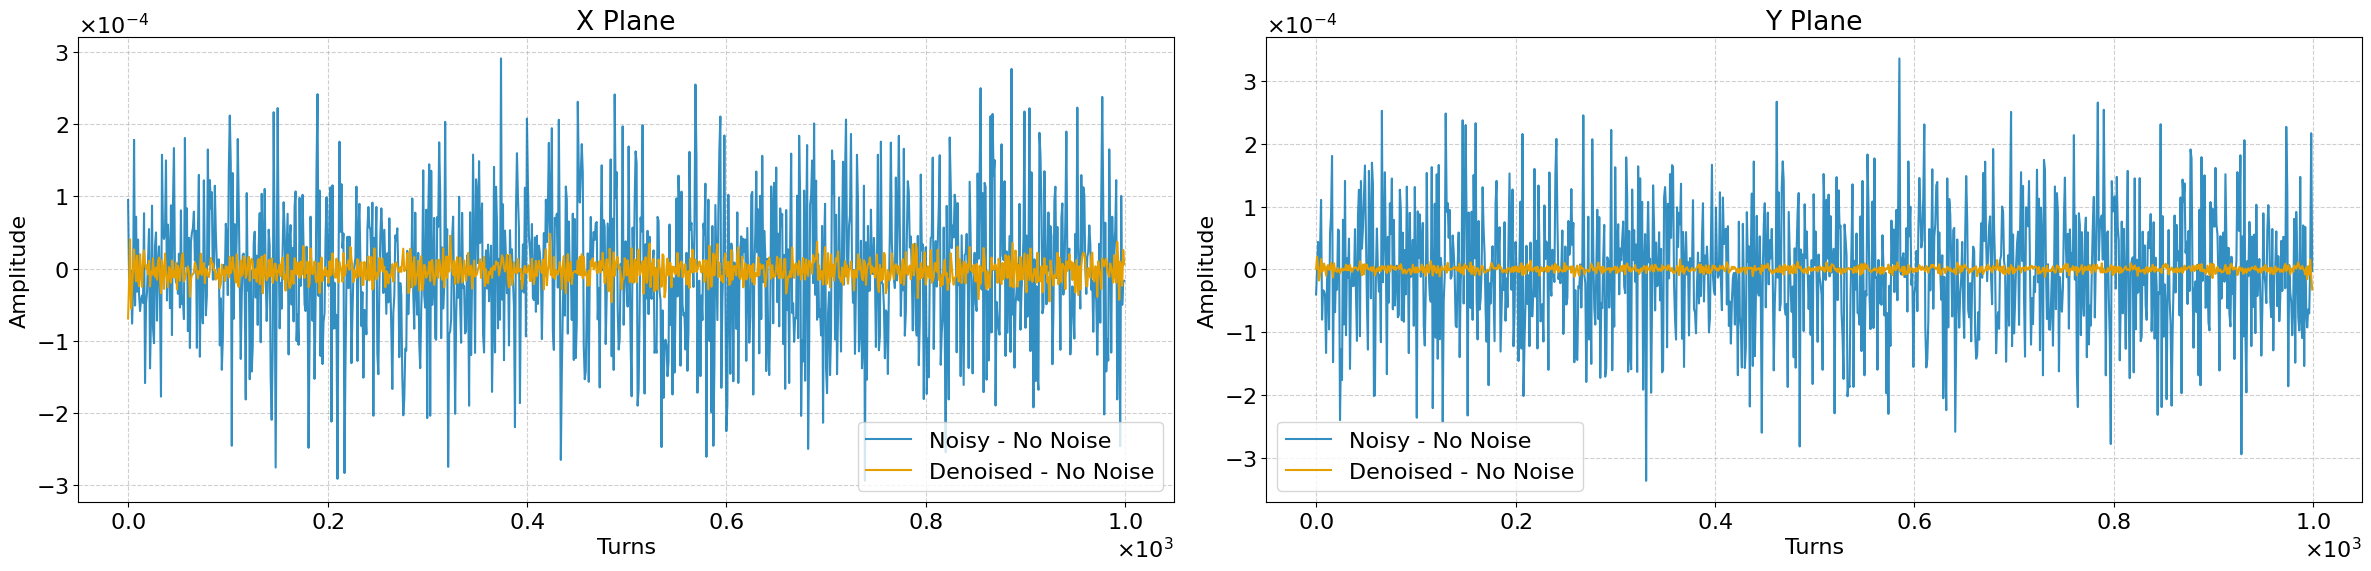

In [3]:
plot_denoised_data_from_files(tbt_file_auto, tbt_file_noisy, tbt_file_zero, 111)
plt.show()

In [4]:
run_harpy(BEAM, tbt_file_auto, clean=False, turn_bits=18)
print("Done running Harpy on cleaned data from the autoencoder")

Done running Harpy on cleaned data from the autoencoder


In [10]:
CLEAN_HARPY = False
if CLEAN_HARPY:
    tbt_file = tbt_file_clean
else:
    tbt_file = tbt_file_noisy
run_harpy(BEAM, tbt_file, clean=CLEAN_HARPY, turn_bits=18)
print(f"Done running Harpy on noisy data, {'not ' if not CLEAN_HARPY else ''}cleaned using Harpy")

Done running Harpy on noisy data, not cleaned using Harpy


In [6]:
run_harpy(BEAM, tbt_file_zero, clean=False, turn_bits=18)
print("Done running Harpy on no noise data")

Done running Harpy on no noise data


BPM.31L4.B1
BPM.31L4.B1


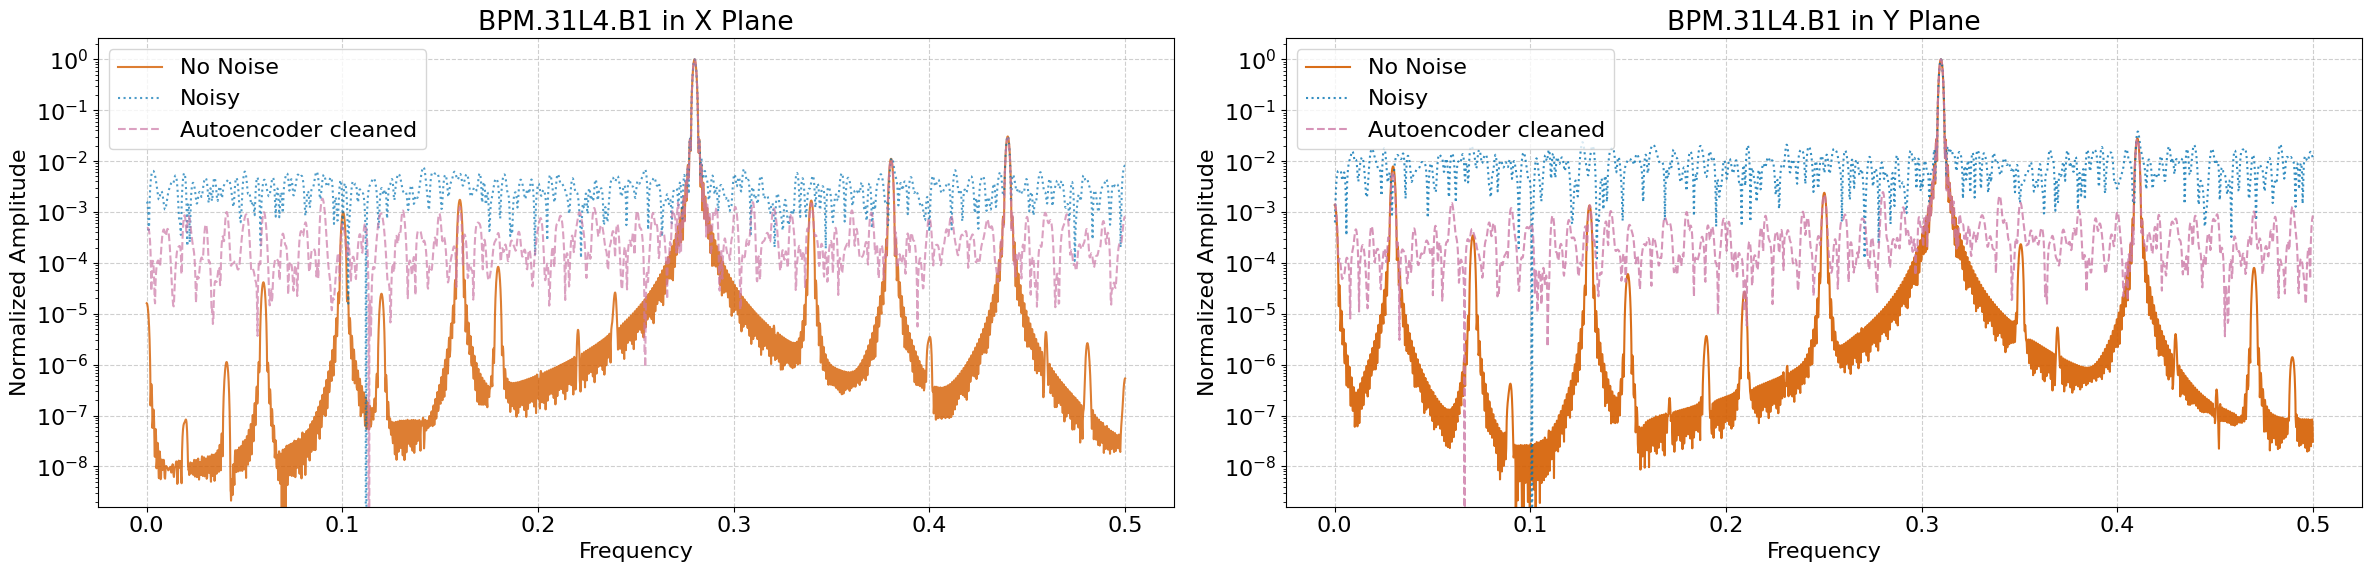

In [12]:
def normalise_df(df: tfs.TfsDataFrame):
    return (df - df.min()) / (df.max() - df.min())

plt.rcParams.update({"font.size": 16})

# Define mapping for each state
states = ["clean", "noisy", "nonoise"]

# Map state to plot labels (note: we assume that "nonoise" is the denoised case)
labels = {
    "nonoise": "No Noise",
    "noisy": "Harpy Cleaned" if CLEAN_HARPY else "Noisy",
    "clean": "Autoencoder cleaned",
}
# Define linestyles (None means default solid line)
linestyles = {"nonoise": None, "noisy": "dotted", "clean": "dashed"}
colors = {
    "nonoise": COLOURS[1], 
    "noisy": COLOURS[2 if CLEAN_HARPY else 0], 
    "clean": COLOURS[6]
    }

# Assuming you have these path variables already defined:
paths = {
    "clean": tbt_file_auto,
    "noisy": tbt_file,
    "nonoise": tbt_file_zero,
}
BPM_INDEX = 111

# Dictionaries to hold frequency and amplitude data for X and Y
freqs_x, amps_x = {}, {}
freqs_y, amps_y = {}, {}

for state in states:
    path = paths[state]
    # Load and normalize X data
    freqs_x[state] = tfs.read(FREQ_OUT_DIR / (path.name + ".freqsx"))
    amps_x[state] = normalise_df(tfs.read(FREQ_OUT_DIR / (path.name + ".ampsx")))

    # Load and normalize Y data
    freqs_y[state] = tfs.read(FREQ_OUT_DIR / (path.name + ".freqsy"))
    amps_y[state] = normalise_df(tfs.read(FREQ_OUT_DIR / (path.name + ".ampsy")))

# Select a BPM channel using the same index for both X and Y
BPM_NAME_x = amps_x["clean"].columns[BPM_INDEX]
print(BPM_NAME_x)
BPM_NAME_y = amps_y["clean"].columns[BPM_INDEX]
print(BPM_NAME_y)

# Define the order in which to plot (to match your example: denoised, noisy, then clean)
plot_order = ["nonoise", "noisy", "clean"]

# Create subplots for X and Y
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Plot X plane data
for state in plot_order:
    axs[0].plot(
        freqs_x[state][BPM_NAME_x],
        amps_x[state][BPM_NAME_x],
        label=labels[state],
        linestyle=linestyles[state],
        color = colors[state],
        alpha=0.8 if state == "nonoise" else 0.7,
    )
axs[0].set_title(f"{BPM_NAME_x} in X Plane")
axs[0].legend()

# Plot Y plane data
for state in plot_order:
    axs[1].plot(
        freqs_y[state][BPM_NAME_y],
        amps_y[state][BPM_NAME_y],
        label=labels[state],
        linestyle=linestyles[state],
        color = colors[state],
        alpha=0.9 if state == "nonoise" else 0.8,
    )
axs[1].set_ylabel("Normalized Amplitude")
axs[1].set_title(f"{BPM_NAME_y} in Y Plane")
for ax in axs:
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_yscale("log")
    ax.set_ylim(10**-8.791334934248553, 10**0.4132279093016276)


plt.tight_layout()
filename = "harpy_spectrum.png" if CLEAN_HARPY else "harpy_spectrum_noisy.png"
plt.savefig(filename, bbox_inches="tight", dpi=300)
plt.show()


In [8]:
print("Running optics analysis on the data")
cleaned_dfs = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=tbt_file_auto)
hcleaned_dfs = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=tbt_file)
nonoise_rdts = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=tbt_file_zero)
print("Done running optics analysis")

Running optics analysis on the data


NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.


Tunes for beam 1: [np.float64(0.279993169049), np.float64(0.309805817545)]


/home/jovyan/autocleaner/rdt_functions.py:109: DeprecationWarning: invalid escape sequence '\ '
  mad.send(f"""
/home/jovyan/autocleaner/rdt_functions.py:248: DeprecationWarning: invalid escape sequence '\s'
  mad.send(f"""


KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({"font.size": 24})
for rdt in ["f1020_x", "f1011_y"]:
    plt.figure(figsize=(12, 12))
    plt.plot(nonoise_rdts[rdt]["S"], nonoise_rdts[rdt]["AMP"], label="No Noise", color=COLOURS[1])
    plt.plot(
        hcleaned_dfs[rdt]["S"],
        hcleaned_dfs[rdt]["AMP"],
        label=f"Harpy {CLEAN_HARPY and 'Cleaned' or 'Uncleaned'}",
        color=COLOURS[2],
        linestyle="dotted",
        # marker="+",
    )
    plt.plot(
        cleaned_dfs[rdt]["S"], cleaned_dfs[rdt]["AMP"], label="Autoencoder Cleaned",
        color=COLOURS[0],
        linestyle="dashed",
        # marker="x",
    )
    plt.title(rdt + f" at {format_noise(NOISE)}")
    plt.xlabel("s [m]")
    plt.ylabel("RDT Ampltitude [$m^{-1/2}$]")
    plt.legend()
    if not CLEAN_HARPY:
        rdt += "_unclean"
    plt.savefig(rdt, bbox_inches="tight", dpi=300)
    plt.legend()
plt.show()